In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size, steps, return_batch_ts=False):
        #Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        #Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        #Create batch tome series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        #Create the y data for the times series x axis fom previous step
        y_batch = np.sin(batch_ts)
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1),batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

In [36]:
ts_data = TimeSeriesData(250,0,10)

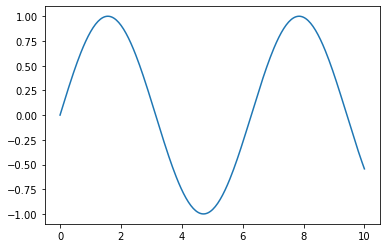

In [37]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [38]:
num_time_steps = 50

In [39]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

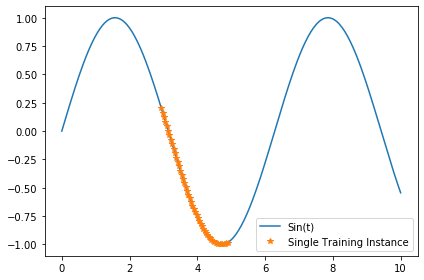

In [40]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [41]:
# TRAINING DATA

In [42]:
train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [43]:
train_inst

array([5.    , 5.0408, 5.0816, 5.1224, 5.1632, 5.204 , 5.2448, 5.2856,
       5.3264, 5.3672, 5.408 , 5.4488, 5.4896, 5.5304, 5.5712, 5.612 ,
       5.6528, 5.6936, 5.7344, 5.7752, 5.816 , 5.8568, 5.8976, 5.9384,
       5.9792, 6.02  , 6.0608, 6.1016, 6.1424, 6.1832, 6.224 , 6.2648,
       6.3056, 6.3464, 6.3872, 6.428 , 6.4688, 6.5096, 6.5504, 6.5912,
       6.632 , 6.6728, 6.7136, 6.7544, 6.7952, 6.836 , 6.8768, 6.9176,
       6.9584, 6.9992, 7.04  ])

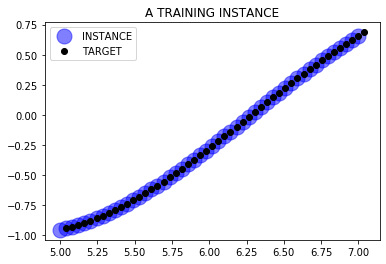

In [44]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize=6,label='TARGET')
plt.legend()

## Criando o Modelo

In [45]:
tf.reset_default_graph()

In [46]:
num_inputs = 1

In [47]:
num_neurons = 100

In [48]:
num_output = 1

In [49]:
learning_rate = 0.0001


In [50]:
num_train_iterations = 2000

In [51]:
batch_size = 1

In [52]:
# PLACEHOLDERS
x = tf.placeholder(tf.float32,[None,num_time_steps, num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps, num_output])

In [53]:
# RNN Cell Layer
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),output_size=num_output)

In [54]:
outputs, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

In [55]:
# Erro Medio Quadratico
loss = tf.reduce_mean(tf.square(outputs-y))
optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [56]:
train = optmizer.minimize(loss)

In [57]:
init = tf.global_variables_initializer()

In [58]:
# SESSION
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={x:X_batch,y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
            
    saver.save(sess,"./rnn_time_series_model_codealong")

0 	MSE 0.2576876
100 	MSE 0.40173846
200 	MSE 0.029029699
300 	MSE 0.009897935
400 	MSE 0.00591526
500 	MSE 0.010428024
600 	MSE 0.005623472
700 	MSE 0.0123346625
800 	MSE 0.009817407
900 	MSE 0.0079996055
1000 	MSE 0.002679279
1100 	MSE 0.016749665
1200 	MSE 0.0010339143
1300 	MSE 0.007841766
1400 	MSE 0.005517728
1500 	MSE 0.009085737
1600 	MSE 0.0077384263
1700 	MSE 0.004384913
1800 	MSE 0.0017037705
1900 	MSE 0.00044004712


In [59]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_codealong")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={x:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


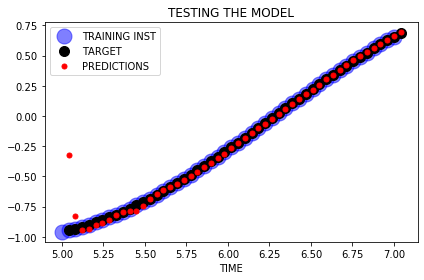

In [60]:
plt.title("TESTING THE MODEL")
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label="TRAINING INST")
plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize=10,label="TARGET")
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,label="PREDICTIONS")
plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

## Gerando uma nova sequência

In [61]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_codealong")
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iterarion in range(len(ts_data.x_data)-num_time_steps):
        x_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={x:x_batch})
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0, 0.5, 'Y')

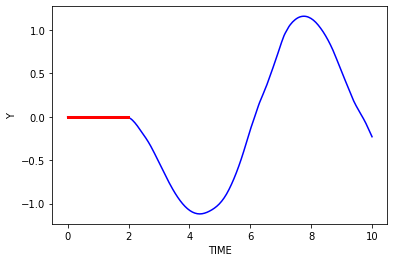

In [62]:
plt.plot(ts_data.x_data, zero_seq_seed,'-b')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')

In [63]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_codealong")
    training_instance = list(ts_data.y_true[:30])
    for iterarion in range(len(training_instance)-num_time_steps):
        x_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={x:x_batch})
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


TypeError: can only concatenate list (not "int") to list

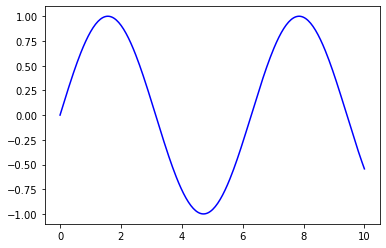

In [65]:
plt.plot(ts_data.x_data, ts_data.y_true,'b-')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')